# NLP & W2VEC

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import json

from wordcloud import WordCloud
from pythainlp.tokenize import THAI2FIT_TOKENIZER # ใช้ในการตัดคำ
from pythainlp.corpus import common # ใช้ลบคำที่ไม่ใช้ออก

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize

# Word2Vec
from pythainlp.word_vector import WordVector

# AI
from sklearn.model_selection import train_test_split # split data set
from sklearn.metrics import accuracy_score, classification_report # report train & test result

# AI Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Hyperparameter Tunning
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from skopt.plots import plot_objective, plot_histogram

# Saving Intelligence
from joblib import dump, load


In [2]:
data = pd.read_csv("./data/data1671694184.csv")
data = data[['message', 'category']]

In [3]:
data.head()

,message,category
0,positionผมได้วิเคราะห์ไว้แล้ว,A
1,แบบฝึกไหน555,A
2,เพิ่งทำเสร็จเลย,A
3,มีสอบปลายภาค,A
4,ตอนนี้ผมยังเตรียมข้อมูลใน LMS และ Google Class...,A


### Data Features and Values

In [4]:
def clean_data(data):
    # filter common chat
    # data = data.drop(data.index[ data['category'] == 'C' ])
    # sort data by category
    data = data.sort_values(by=['category'])

    data = data.reset_index()
    data = data[['message', 'category']]

    return data

In [5]:
data = clean_data(data)

In [6]:
category_list = data['category'].unique()
category_list

array(['A', 'C', 'Q', 'S', 'T'], dtype=object)

In [7]:
data.shape

(15712, 2)

In [8]:
data.dtypes

message     object
category    object
dtype: object

In [9]:
data.isnull().any()

message     False
category    False
dtype: bool

### Countplot of target Variable(Category)

In [10]:
def plot_count_graph(data):
    count_graph = sns.countplot(data)
    count_list = []

    for p in count_graph.patches:
        height = p.get_height()
        count_list.append(height)
        count_graph.annotate('{:.1f}'.format(height), (p.get_x()+0.25, height+0.01))

    plt.show()

c:\Users\USER\dev\chat-topic-classification\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


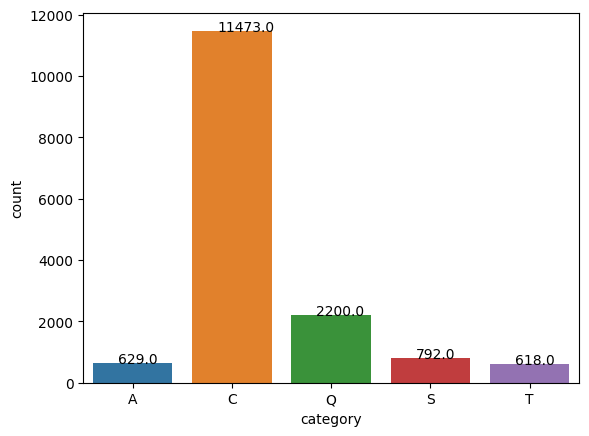

In [11]:
plot_count_graph(data['category'])

### Balancing Category

In [12]:
def balance_data(nb_data, field, field_list, is_string_list=False, n=600):
    df_list = []
    for f in field_list:
        if(is_string_list):
            f = f"'{f}'" #stringify

        temp_data = nb_data.query(f"{field} == {f}").sample(
            n= n,
            replace=False, #True if numbers of sample higher than minimum numbers of category
            random_state=18, 
        )

        df_list.append(temp_data)
    return df_list

In [13]:
data_full = data

df_list = balance_data(
    data, field= 'category', 
    field_list= data['category'].unique(), 
    is_string_list=True,
    n=600
)
data = clean_data(data= pd.concat(df_list))

c:\Users\USER\dev\chat-topic-classification\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


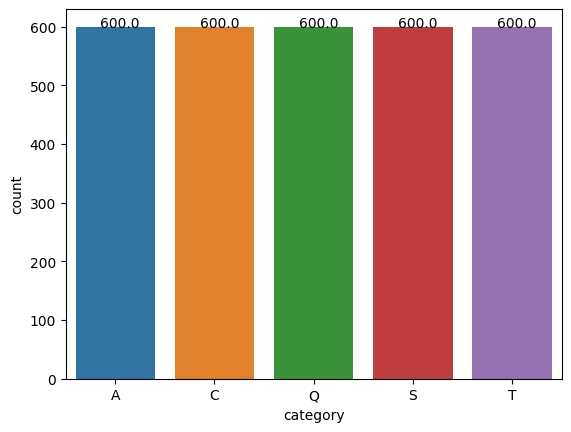

In [14]:
plot_count_graph(data['category'])

In [15]:
data['message_length'] = data['message'].str.len()
print(data['message_length'])

0       41
1       35
2       40
3       13
4       15
        ..
2995    22
2996     7
2997    24
2998    28
2999    38
Name: message_length, Length: 3000, dtype: int64


### Words Distribution Plot

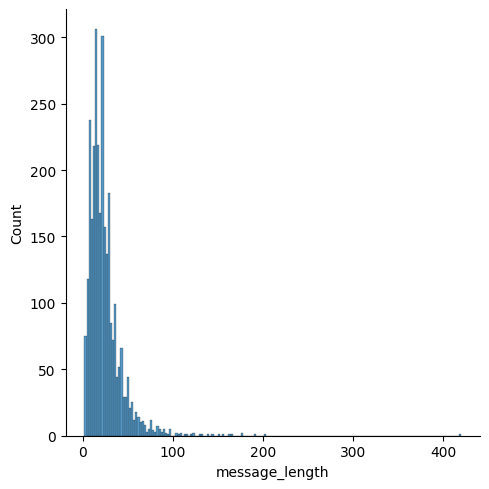

In [16]:
sns.displot(data['message_length']).set_titles('message_length')

### Count Words

In [17]:
def count_words(category=''):
    word_list = set()
    if(category != ''):
        sub_frame = data[data['category']==category]
    else:
        sub_frame = data

    for text in sub_frame['message']:
        
        text = text.lower().replace('\n', ' ').replace('\r', '').strip()
        text = re.findall(r"[\u0E00-\u0E7Fa-zA-Z']+", text)
        text = ' '.join(text)

        word_tokens = THAI2FIT_TOKENIZER.word_tokenize(text)
        filtered_sentence = set([w for w in word_tokens])

        word_list.update(filtered_sentence)

    return len(word_list)

In [18]:
words_category = []
for category in category_list:
    words_category.append(count_words(category))

words_category

[1016, 1046, 863, 922, 934]

In [19]:
print('Total Word:')
print(count_words())

Total Word:
2537


<AxesSubplot: xlabel='category', ylabel='words_count'>

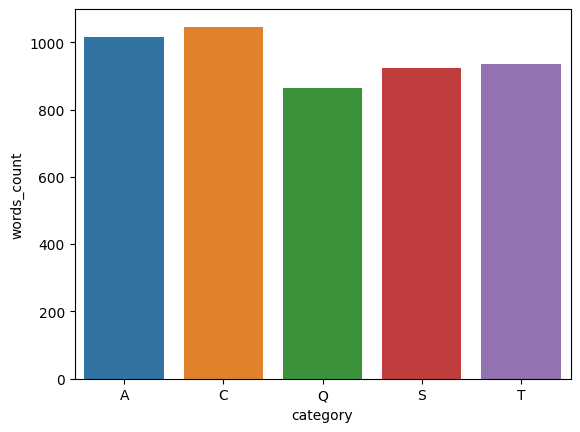

In [20]:
words_count = {'category': category_list, 'words_count': words_category}
w_count_data = pd.DataFrame(words_count)
sns.barplot(x= 'category', y='words_count', data=w_count_data)

### Word Cloud

In [21]:
def create_wordcloud(words):
    wordcloud = WordCloud(font_path='THSarabun.ttf', # path ที่ตั้ง Font
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+" # ป้องกัน bug วรรณยุกต์
                      ).generate(' '.join(THAI2FIT_TOKENIZER.word_tokenize(words)))
    plt.figure(figsize=[10, 7])
    plt.imshow(wordcloud, interpolation= "bilinear")
    plt.axis('off')
    plt.show()

In [22]:
def check_wordcloud(category):
    subset = data[data.category==category]
    text = subset.message.values
    words = ''.join(text)
    create_wordcloud(words)

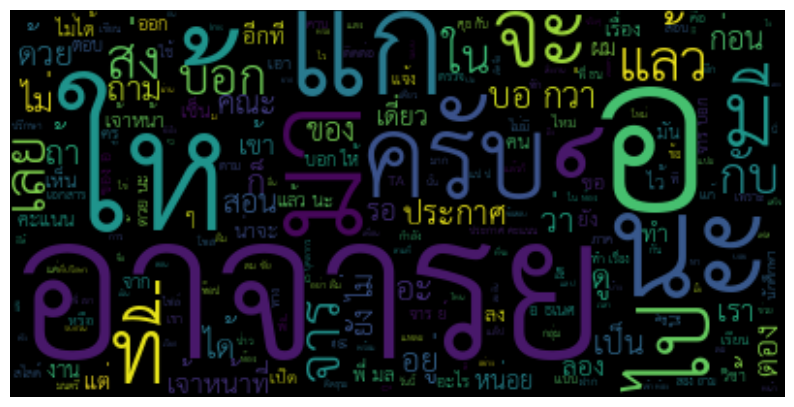

In [23]:
check_wordcloud('T')

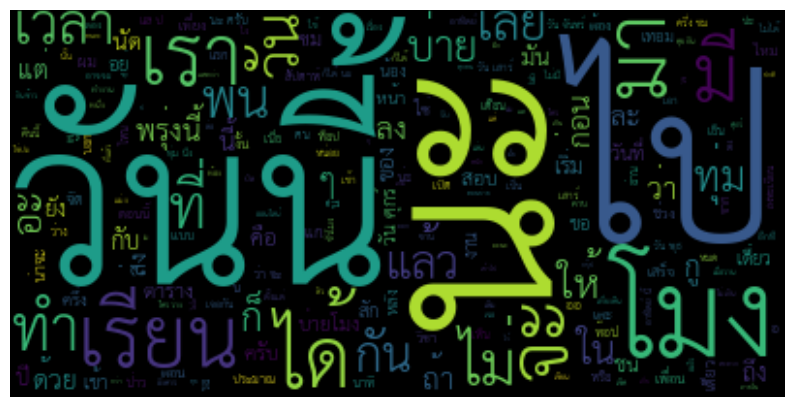

In [24]:
check_wordcloud('S')

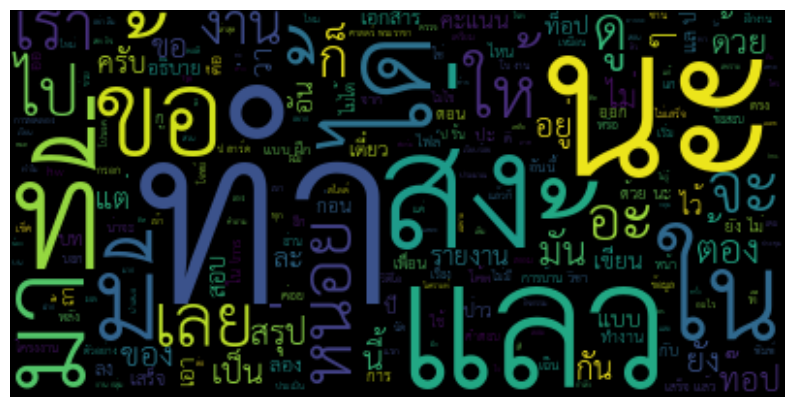

In [25]:
check_wordcloud('A')

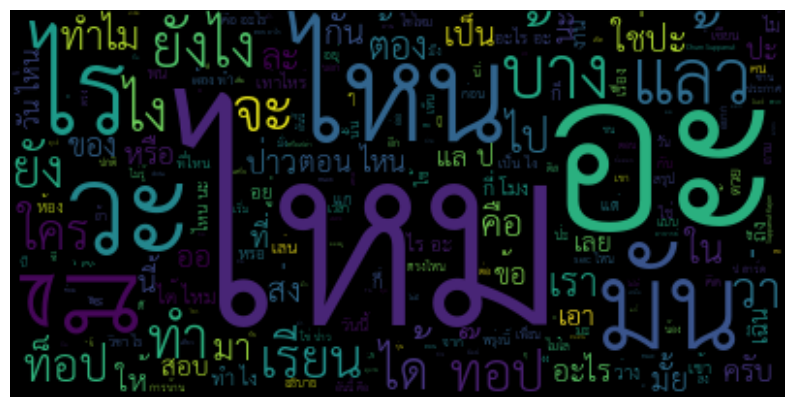

In [26]:
check_wordcloud('Q')

### Label Encoding

In [27]:
label_encoder = preprocessing.LabelEncoder()
data['category_target'] = label_encoder.fit_transform(data['category'])

In [28]:
temp_data = data[['category', 'category_target']].drop_duplicates()
print(temp_data)


     category  category_target
0           A                0
600         C                1
1200        Q                2
1800        S                3
2400        T                4


In [29]:
# keep category target in json
json_classes = temp_data.to_json(orient="records")
json_file = 'classes.json'

# Writing to .json
with open(json_file, "w") as outfile:
    outfile.write(json_classes)


In [30]:
# Opening JSON file
with open(json_file, 'r') as openfile:
    # Reading from json file
    temp_json = json.load(openfile)
    print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'C', 'category_target': 1}, {'category': 'Q', 'category_target': 2}, {'category': 'S', 'category_target': 3}, {'category': 'T', 'category_target': 4}]


In [31]:
temp_json.sort(key=lambda item : item['category_target'])
print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'C', 'category_target': 1}, {'category': 'Q', 'category_target': 2}, {'category': 'S', 'category_target': 3}, {'category': 'T', 'category_target': 4}]


In [32]:
classes_list = [ item['category'] for item in temp_json]
print(classes_list)

['A', 'C', 'Q', 'S', 'T']


### Word2Vec

In [33]:
w2v_thai = WordVector()

In [34]:

word2vec = [w2v_thai.sentence_vectorizer(data['message'][i]) 
            for i in range(0,len(data['message']))]

In [35]:
X = np.array(word2vec).tolist()

data['word2vec'] = X


In [36]:
# reshape
data_reshape = np.reshape(X, (-1, 300))

In [37]:
print(data_reshape.shape)

(3000, 300)


In [38]:
data.head()

,message,category,message_length,category_target,word2vec
0,มันเป็นเขียนสรุปสิ่งที่ได้เรียนรู้จากคลิป,A,41,0,"[[-0.0565808033104986, -0.1808738050982356, 0...."
1,งาน ก็มี ช่วยดูระหว่างน้องลงแลบ ค่ะ,A,35,0,"[[-0.03348169126547873, -0.09583638465175262, ..."
2,ถ้าแก้ตามที่บอกทั้งหมดแล้ว ก็หมดแล้วแหละ,A,40,0,"[[-0.09390191128477454, -0.10458936474540016, ..."
3,ตอนส่งเป็นpdf,A,13,0,"[[-0.23129249643534422, -0.013398244976997375,..."
4,ท๊อปทำเอกสารยัง,A,15,0,"[[-0.04998625069856644, 0.14781874511390924, 0..."


# AI MODEL

### Split the data in Training and Testing

In [39]:
data_temp = [ x for x in data['word2vec']]
data_reshape = np.reshape(data_temp, (-1, 300))
data_reshape.shape


(3000, 300)

### Split Train, Test Data

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data_reshape,
                                                    data['category_target'],
                                                    random_state=18,
                                                    test_size = 0.2,
                                                    shuffle=True
                                                    )

In [41]:
print(X_train.shape)
print(y_train.shape)

(2400, 300)
(2400,)


In [42]:
print(X_test.shape)
print(y_test.shape)

(600, 300)
(600,)


In [43]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

dump(scaler, './models/scaler.joblib')


['./models/scaler.joblib']

### Models Predictions

In [44]:
# MLP Model
mlp_model = MLPClassifier(
    hidden_layer_sizes= (20,), 
    early_stopping= True,
)
mlp_model.fit(X_train, y_train)

accuracy_predictions = mlp_model.predict(X_train)
print('Validation', accuracy_score(y_train, accuracy_predictions))

model_predictions = mlp_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))

print(classification_report(y_test, model_predictions))

Validation 0.8066666666666666
Accuracy 0.6533333333333333
              precision    recall  f1-score   support

           0       0.57      0.58      0.57       112
           1       0.54      0.50      0.52       129
           2       0.64      0.60      0.62       110
           3       0.65      0.72      0.68       116
           4       0.85      0.85      0.85       133

    accuracy                           0.65       600
   macro avg       0.65      0.65      0.65       600
weighted avg       0.65      0.65      0.65       600



### Load Saved Model

In [45]:
# mlp_model = load('./models/mlp_model.joblib') 

In [46]:
# accuracy_predictions = mlp_model.predict(X_train)
# print('Validation', accuracy_score(y_train, accuracy_predictions))

# model_predictions = mlp_model.predict(X_test)
# print('Accuracy', accuracy_score(y_test, model_predictions))

# print(classification_report(y_test, model_predictions))

### Save AI Model

In [47]:
# dump(mlp_model, './models/mlp_model.joblib')

### BayesSearch Hyperparameter Tunning

<!-- Suggest Config RandomForest example
{'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
        2378, 2585, 2792, 3000]),
 'max_depth': [1, 5, 10, 20, 50, 75, 100, 150, 200],
 'min_samples_split': [1, 2, 5, 10, 15, 20, 30],
 'min_samples_leaf': [1, 2, 3, 4],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy']} -->

In [48]:
# model = MLPClassifier(hidden_layer_sizes= (20,), early_stopping= True)
# opt = BayesSearchCV(
#     model,
#     {
#         'solver': Categorical(['lbfgs', 'sgd', 'adam']),
#         # 'alpha': Real(1e-7, 1e-1,prior='log-uniform')
#     }
#     , verbose= 1
#     , random_state= 18
#     , n_iter= 50
# )
# opt.fit(X_train, y_train)

In [49]:
# print(opt.best_score_)
# print(opt.best_params_)

In [50]:
# plot_objective(opt.optimizer_results_[0],
#                    dimensions=[
#                    'solver',
#                 #    'alpha'
#                     ],
#                    n_minimum_search=int(1e8))
# plt.show()

# Use Case with Modules


In [51]:
from project_module.message_classifier import MessageClassifier

In [52]:
c_classifier = MessageClassifier()

In [53]:
c_classifier.load_model(
    model_path='./models/mlp_model.joblib',
    json_classes_path='./classes.json',
    scaler_path='./models/scaler.joblib',
)

In [54]:
start_time = time.time()
result = c_classifier.classify(text_input='งานต้องส่งนะ')
print(f'{result} take {time.time()-start_time} seconds')

['A', 0.9766372946526987] take 0.0009999275207519531 seconds


### Prepare CommonChat Filter

In [55]:
message_classifier = MessageClassifier()

In [56]:
message_classifier.load_model(
    model_path='./models/mlp_model.joblib',
    json_classes_path='./classes.json',
    scaler_path='./models/scaler.joblib',
)

In [57]:
data_full['predict_proba'] = [ p for p in message_classifier.predict_proba_from_text(data_full['message']) ]

In [58]:
isCommon_list = []
for p in data_full['category']:
    if(p == 'C'):
        isCommon_list.append(1)
    else:
        isCommon_list.append(0)
        
data_full['isCommon'] = isCommon_list
data_full.head()

,message,category,predict_proba,isCommon
0,positionผมได้วิเคราะห์ไว้แล้ว,A,"[0.12733284364656952, 0.20956479189513935, 0.2...",0
1,ท็อปเสดละขอมั่ง,A,"[0.11792973443041585, 0.19442925298862307, 0.2...",0
2,ก่อนงานอันใหญ่,A,"[0.13126934164770346, 0.2104371704492961, 0.18...",0
3,อย่าลืมพิมพ์เอกสาร แล้วก็แลปชีทของแลปฮาร์ดกันม...,A,"[0.13027550606966273, 0.20004105958272833, 0.1...",0
4,มีทำแบบฝึก3 ตอบคำถามจากpointและวิดีโอศึกษาชุมช...,A,"[0.12819942621100508, 0.18305791436055172, 0.1...",0


In [59]:
c_data = data_full
len(c_data)

15712

c:\Users\USER\dev\chat-topic-classification\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


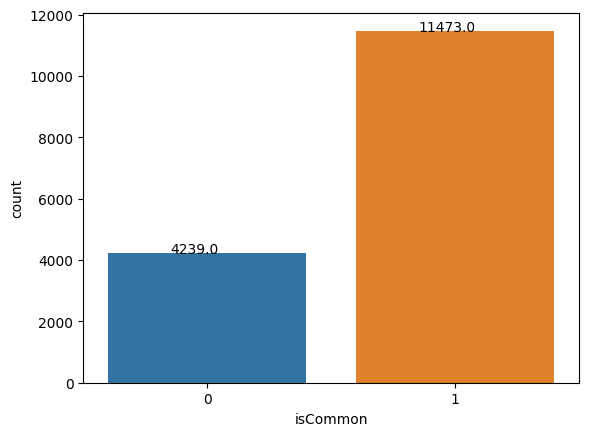

In [60]:
plot_count_graph(c_data['isCommon'])

In [61]:
c_temp_data = balance_data(
    c_data, field= 'isCommon', 
    field_list= c_data['isCommon'].unique(), 
    n=int(4230)
)

c_data = pd.concat(c_temp_data)
c_data.head()

,message,category,predict_proba,isCommon
15417,มีประกาศคะแนนแล้วนะ,T,"[0.122352262982262, 0.19553991773872204, 0.172...",0
13908,ส่งทางไหนนะ,Q,"[0.12495047502929096, 0.1706741419517435, 0.24...",0
14455,พรุ่งนี้ใครว่าง เข้าซูมเจอน้องด้วยน้า,S,"[0.09156418907221842, 0.2077461262216418, 0.21...",0
14725,เดะคืนนี้เช็คตารางอีกที,S,"[0.09854866521492439, 0.18375823860535365, 0.2...",0
12905,ส่งอันนี้ให้อาจารออ,Q,"[0.13720785036396235, 0.19036741523051953, 0.2...",0


In [62]:
C = c_data['predict_proba'].tolist()
c_reshape = np.reshape(C, (-1, 5))

c_reshape = normalize(c_reshape)

In [63]:
label_train, label_test, result_train, result_test = train_test_split(
                                                    c_reshape,
                                                    c_data['isCommon'],
                                                    random_state=18,
                                                    test_size = 0.2,
                                                    shuffle=True
                                                    )

In [64]:
print(label_train.shape)
print(result_train.shape)
print(label_test.shape)
print(result_test.shape)

(6768, 5)
(6768,)
(1692, 5)
(1692,)


In [65]:
opt_model = RandomForestClassifier()
opt_model.fit(label_train, result_train)

a_predictions = opt_model.predict(label_train)
print('Validation', accuracy_score(result_train, a_predictions))

common_predictions = opt_model.predict(label_test)
print('Accuracy', accuracy_score(result_test, common_predictions))

print(classification_report(result_test, common_predictions))

Validation 0.9976359338061466
Accuracy 0.7157210401891253
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       865
           1       0.71      0.72      0.71       827

    accuracy                           0.72      1692
   macro avg       0.72      0.72      0.72      1692
weighted avg       0.72      0.72      0.72      1692



# Dump resource file

In [66]:
dump(mlp_model, './models/mlp_model.joblib')
dump(scaler, './models/scaler.joblib')
dump(opt_model, './models/opt_model.joblib')

['./models/opt_model.joblib']

# Usable Model

In [69]:
message_classifier_final = MessageClassifier()
message_classifier_final.load_model(
    model_path='./models/mlp_model.joblib',
    optimizer_path='./models/opt_model.joblib',
    json_classes_path='./classes.json',
    scaler_path='./models/scaler.joblib',
)

In [70]:
accuracy_predictions = message_classifier_final.predict(X_train)
print('Validation', accuracy_score(y_train, accuracy_predictions))

model_predictions = message_classifier_final.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))

print(classification_report(y_test, model_predictions))

Validation 0.80625
Accuracy 0.6533333333333333
              precision    recall  f1-score   support

           0       0.57      0.57      0.57       112
           1       0.54      0.51      0.52       129
           2       0.64      0.60      0.62       110
           3       0.65      0.72      0.68       116
           4       0.85      0.85      0.85       133

    accuracy                           0.65       600
   macro avg       0.65      0.65      0.65       600
weighted avg       0.65      0.65      0.65       600

